In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
use_bias = not True
train_size = 1000
test_size = 500

In [3]:
# генерация набора данных
def generate_data(size):
    s = int(size / 2)
    x_1 = tf.random.uniform(shape = [s, ], minval = 0.5, maxval = 10.01)
    x_2 = tf.random.uniform(shape = [s, ], minval = 0.5, maxval = 10.01)
    x_1 = tf.stack([x_1, x_2], axis = 1)
    y_1 = tf.ones(shape = [s, ])
    
    z_1 = tf.random.uniform(shape = [s, ], minval = 10.5, maxval = 20.01)
    z_2 = tf.random.uniform(shape = [s, ], minval = 10.5, maxval = 20.01)
    x_2 = tf.stack([z_1, z_2], axis = 1)
    y_2 = tf.zeros(shape = [s, ])
    
    x = tf.concat([x_1, x_2], axis = 0)
    y = tf.concat([y_1, y_2], axis = 0)
    
    return x, y

In [4]:
# подготовка обучающих и проверочных множеств
x_train, y_train = generate_data(train_size)
x_test, y_test = generate_data(test_size)

In [5]:
x_train.shape

TensorShape([1000, 2])

In [6]:
scaler = StandardScaler(copy = False).fit(x_train)

In [7]:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

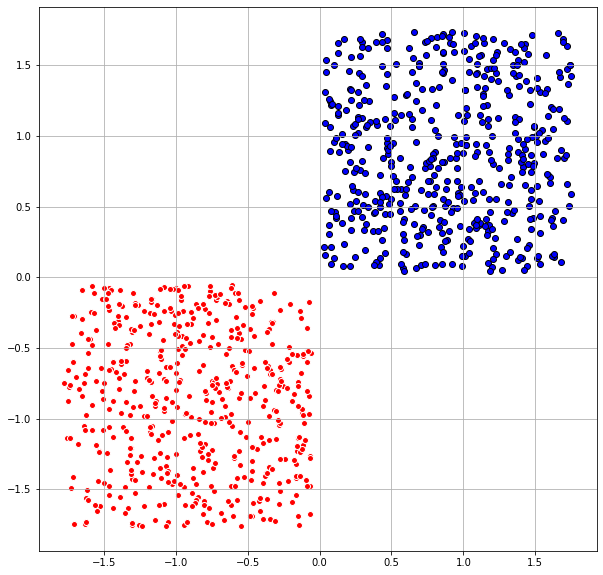

In [8]:
# отображение обучающего набора
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.grid()
s = int(y_train.shape[0] / 2)
for i in range(s):
    ax.scatter(x_train[i, 0], x_train[i, 1], marker = 'o', c = 'red', edgecolor = 'white')
    ax.scatter(x_train[s + i, 0], x_train[s + i, 1], marker = 'o', c = 'blue', edgecolor = 'black')
plt.show()

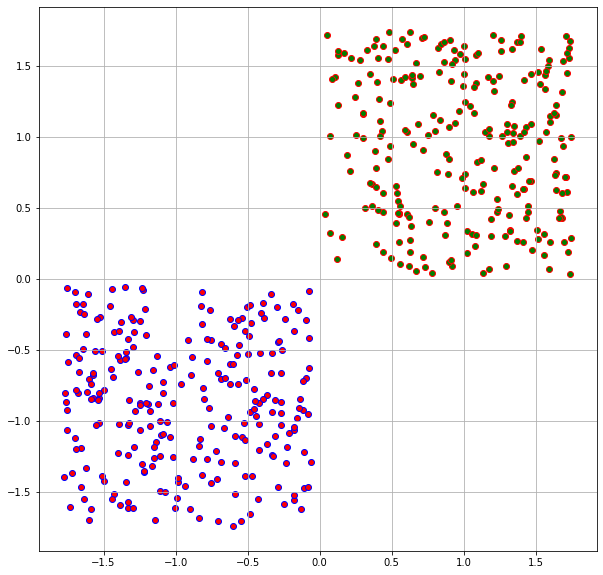

In [9]:
# отображение проверочного набора
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.grid()
s = int(y_test.shape[0] / 2)
for i in range(s):
    ax.scatter(x_test[i, 0], x_test[i, 1], marker = 'o', c = 'red', edgecolor = 'blue')
    ax.scatter(x_test[s + i, 0], x_test[s + i, 1], marker = 'o', c = 'green', edgecolor = 'red')
plt.show()

In [8]:
x_train = tf.constant(x_train, dtype = tf.float32)
x_test = tf.constant(x_test, dtype = tf.float32)

In [9]:
# формирование и обучение модели НС
class Dense(tf.Module):
    def __init__(self, outputs, activate="relu", use_bias = True):
        super().__init__()
        self.outputs = outputs
        self.activate = activate
        self.use_bias = use_bias
        self.fl_init = False

    def __call__(self, x):
        if not self.fl_init:
            self.w = tf.random.truncated_normal((x.shape[-1], self.outputs), stddev=0.1, name="w")
            self.b = tf.zeros(shape = [self.outputs, ], dtype=tf.float32, name="b")

            self.w = tf.Variable(self.w)
            self.b = tf.Variable(self.b, trainable=self.use_bias)

            self.fl_init = True
            
            
        y = x @ self.w + self.b

        if self.activate == "relu":
            return tf.nn.relu(y)
        elif self.activate == "linear":
            return tf.keras.activations.linear(y)
        elif self.activate == "tanh":
            return tf.nn.tanh(y)
        elif self.activate == "leaky_relu":
            return tf.nn.leaky_relu(y)

        return y

In [10]:
model = Dense(1, activate = "leaky_relu", use_bias = use_bias)

In [11]:
loss = lambda x, y: tf.reduce_mean(tf.square(tf.subtract(x, y)))
optimizer = tf.optimizers.Adam(learning_rate=0.01)

In [12]:
epochs = 8
batch_size = 250

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size = 128).batch(batch_size)

In [14]:
# обучение
for i in range(epochs):
    for x_batch, y_batch in train_dataset:
        x_batch = tf.expand_dims(x_batch, axis = 0)
        y_batch = tf.constant(y_batch, shape=(y_batch.shape[0], 1))

        with tf.GradientTape() as tape:
            mod_x = model(x_batch)
            f_loss = loss(y_batch, mod_x)
            mod_x = tf.cast(tf.round(mod_x), dtype = tf.int32)
            y_batch = y_batch.numpy().flatten()
            mod_x = mod_x.numpy().flatten()
            acc = y_batch[y_batch == mod_x].shape[0] / y_batch.shape[0]
            

        grads = tape.gradient(f_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print('loss ', f_loss.numpy(), '\t acc ', acc)

loss  0.019605042 	 acc  0.976
loss  0.024280433 	 acc  0.968
loss  0.010704865 	 acc  0.988
loss  0.01793336 	 acc  0.972
loss  0.024253624 	 acc  0.968
loss  0.011793653 	 acc  0.996
loss  0.011432586 	 acc  0.996
loss  0.023183057 	 acc  0.976


In [15]:
# вывод весов обученного нейрона и смещения (при наличии)
print(model.trainable_variables)

(<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[-0.4073395 ],
       [-0.16363926]], dtype=float32)>,)


In [16]:
# прогноз модели на проверочном множестве
pred = []
for x, y in zip(x_test, y_test):
    x = tf.expand_dims(x, axis = 0)
    y = tf.constant(y, shape=(1, 1))
    mod_x = model(x)
    f_loss = loss(y, mod_x)
    pred.append(mod_x.numpy().flatten())
print(f_loss.numpy())

0.0025515417


In [17]:
pred = tf.cast(tf.round(pred), dtype = tf.int32).numpy().flatten()
pred

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [18]:
y_test = y_test.numpy().flatten()
y_test

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [19]:
acc = y_test[y_test == pred].shape[0] / y_test.shape[0] * 100
print(acc)

76.8


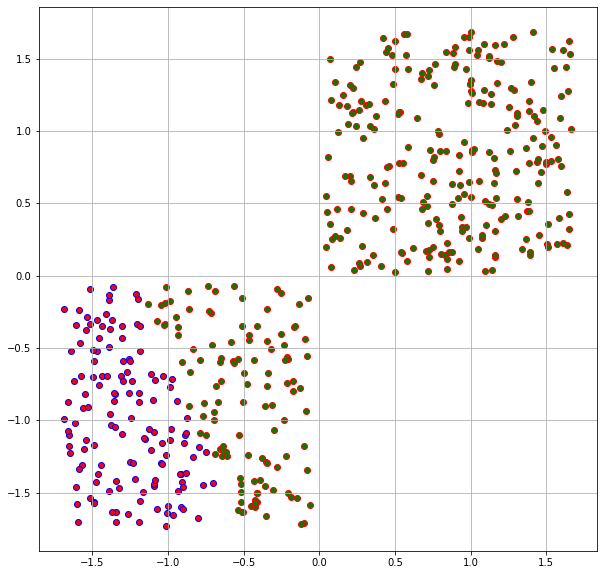

In [20]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.grid()
for i in range(len(pred)):
    if pred[i] == 0:
        ax.scatter(x_test[i, 0], x_test[i, 1], marker = 'o', c = 'green', edgecolor = 'red')
    else:
        ax.scatter(x_test[i, 0], x_test[i, 1], marker = 'o', c = 'red', edgecolor = 'blue')
plt.show()